# nuclei spotter

#### libs


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
import fastai
fastai.__version__

'1.0.52'

In [5]:
torch.cuda.is_available()

True

### look at the data

In [6]:
path = Path('/home/ubuntu/data/fastai/data/nuclei'); 
trn_path = path/'stage1_train'
path.ls()[:5]

[PosixPath('/home/ubuntu/data/fastai/data/nuclei/label'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_train_labels.csv'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_solution.csv'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/test.png'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_test')]

In [7]:
stage1_train_labels = pd.read_csv(path/'stage1_train_labels.csv'); stage1_train_labels.head(2)

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...


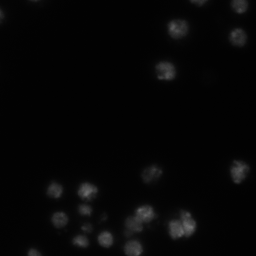

In [8]:
imgId, pixels = stage1_train_labels.iloc[0]
imgPath = path/f'stage1_train/{imgId}/images/{imgId}.png'
open_image(imgPath)

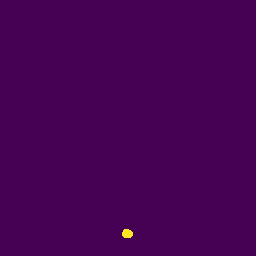

In [9]:
maskPath = path/f'stage1_train/{imgId}/masks'
open_mask(maskPath.ls()[0])

### concatenate masks into 1 file per image

1x image --> 1y mask

In [10]:
def image2np(path):
    x = plt.imread(str(path))
    a = np.asarray(x)
    return a.astype(np.float32, copy=False)
    
def combineMasks(imagePath):
    imgId = imagePath.stem
    imgPath = imagePath/f'images/{imgId}.png'
    imgSize = image2np(imgPath).shape
    all_masks = np.zeros(imgSize[:2])
    masksPath = imagePath.parent/f'{imgId}/masks'

    # add masks to one into 1 image
    for mask in masksPath.ls():
        currMask = image2np(mask)
#         currMask = np.expand_dims(currMask)

        all_masks = np.maximum(all_masks, currMask )
    return all_masks

In [11]:
img_fnames = [ img/f'images/{img.stem}.png' for img in trn_path.ls()]
img_folders = trn_path.ls()

In [12]:
curr_masks = [ [ mask for mask in (folder/'masks').ls()] for folder in img_folders ]

In [13]:
all_masks = reduce((lambda x,y: x + y), curr_masks)

In [14]:
np.amax(image2np(all_masks[0]))

1.0

In [15]:
combineMasks(img_folders[0])

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 0., ..., 1., 1., 1., 1.]])

## move the images to a different folder

put all images at in base level folder 
images
all masks in label folder called labels

In [16]:
def saveArray(path, m):
    pil_image = PIL.Image.fromarray(m).convert("L")
    pil_image.save(path)

In [17]:
train_path = path/'train'
label_path = path/'label'

In [18]:
# copy all images to path/train
for img in tqdm(img_folders):
    imgPath = str(img/f'images/{img.stem}.png')
    newImgPath = str(train_path/f'{img.stem}.png')
#     print(imgPath)
#     print('--> ',newImgPath)
    if not (train_path/f'{img.stem}.png').is_file():
        !cp {imgPath} {newImgPath} 
    
    

100%|██████████| 670/670 [00:00<00:00, 18837.92it/s]


In [19]:
combined_masks = [{ 'name': img.stem,  'mask': combineMasks(img)} for img in img_folders];

In [19]:
# combine then copy all the masks to the train folder
for mask in combined_masks:
    
    maskPath = label_path/f'{mask["name"]}_mask.png'
    if not maskPath.is_file():
        saveArray(str(maskPath),mask["mask"])

NameError: name 'combined_masks' is not defined

In [20]:
new_masks = [ mask for mask in label_path.ls()]

In [21]:
mr = PIL.Image.open(str(new_masks[3]))
np.asarray(mr)

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8)

In [22]:
image_shapes = [ x["mask"].shape[0] for x in combined_masks]
np.amin(image_shapes)

NameError: name 'combined_masks' is not defined

## Now make a databunch!

In [23]:
classes = np.array(["background", "nucleus"], dtype=str); classes

array(['background', 'nucleus'], dtype='<U10')

In [24]:
lng = len(train_path.ls())
valid_pct = int(lng*0.2)
valid_idx = list(range(lng))[:valid_pct]

get_y_fn = lambda x: label_path/f'{x.stem}_mask{x.suffix}'

In [25]:
src = (SegmentationItemList.from_folder(train_path) 
       .split_by_idx(valid_idx)
       .label_from_func(get_y_fn, classes=classes))

In [26]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=10., 
                      max_zoom=1.1, 
                      max_lighting=0.2, 
                      max_warp=0., 
                      p_affine=0.75, 
                      p_lighting=0.75)
# tfms = get_transforms()

In [27]:
data64 = (src.transform(tfms, tfm_y=True, size=64)
       .databunch(bs=64))
# data = src.databunch()

In [28]:
data64.train_ds[4][1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

# The model and learner!

In [29]:
def dice(input:Tensor, targs:Tensor, iou:bool=True)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return 2. * intersect / union
    else: return intersect / (union-intersect+1.0)

In [30]:
dice_iou = partial(dice, iou=True)

In [31]:
torch.cuda.is_available()

True

In [32]:
wd=1e-2

In [33]:
learn = unet_learner(data64, models.resnet34, metrics=dice_iou,  wd=wd)

## size=64

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


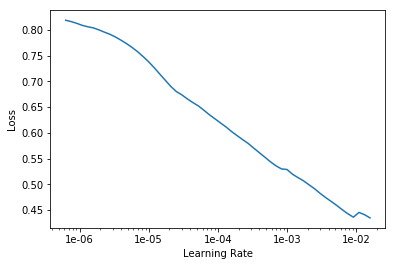

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,dice,time
0,0.515373,0.409782,0.000014,00:08
1,0.414285,0.377065,0.156388,00:06
2,0.333270,0.205942,0.565381,00:06
3,0.277085,0.152440,0.668503,00:06
4,0.238227,0.126046,0.697484,00:06
5,0.211730,0.115654,0.701212,00:06


In [43]:
learn = saveModel('nucleus-stage1-64', learn)

In [44]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


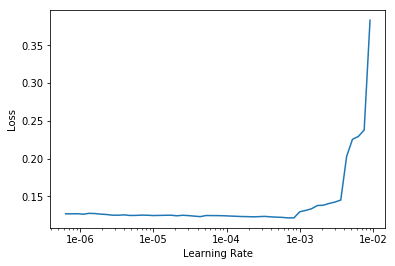

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,dice,time
0,0.125189,0.115314,0.721381,00:06
1,0.124999,0.111074,0.728897,00:06
2,0.121881,0.107119,0.735350,00:06
3,0.119449,0.099894,0.746782,00:06
4,0.117401,0.098188,0.741339,00:06
5,0.115646,0.097995,0.741709,00:07


In [47]:
learn.save('nucleus-stage2-64')

In [48]:
learn = learn.load('nucleus-stage2-64')

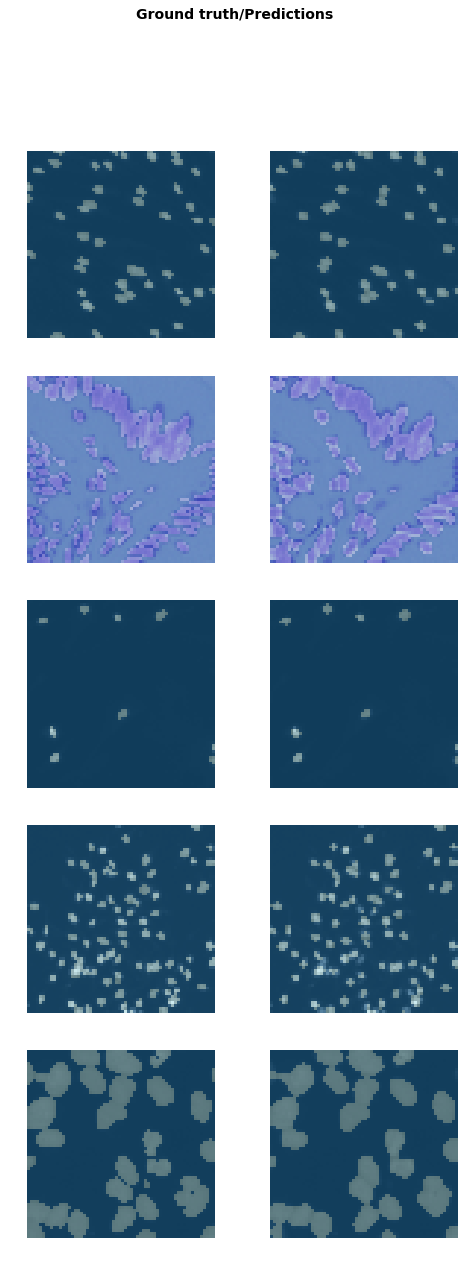

In [49]:
learn.show_results()

## size = 128

In [51]:
size = 128
data128 = (src.transform(tfms, tfm_y=True, size=size)
       .databunch(bs=64))

In [52]:
learn.data = data128

In [53]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


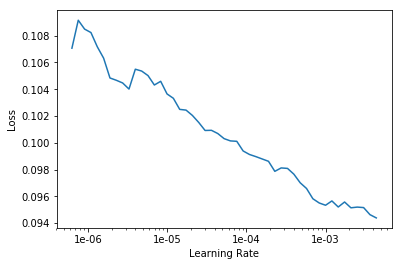

In [54]:
learn.lr_find()
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(6, 1e-5)

epoch,train_loss,valid_loss,dice,time
0,0.102639,0.076579,0.796597,00:20
1,0.098130,0.077643,0.806246,00:17
2,0.095343,0.075967,0.809407,00:17
3,0.093132,0.073346,0.812512,00:17
4,0.091177,0.073103,0.812856,00:17
5,0.089908,0.073009,0.813111,00:17


In [56]:
learn.save('nucleus-stage1-128')

In [57]:
learn = learn.load('nucleus-stage1-128')

In [58]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


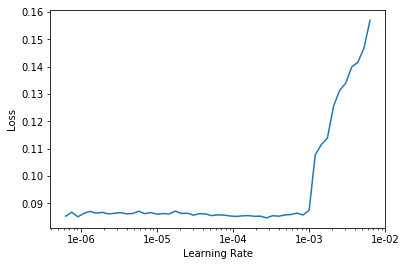

In [59]:
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(6, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice,time
0,0.085644,0.071663,0.816536,00:17
1,0.085341,0.069879,0.822867,00:17
2,0.084529,0.069054,0.825325,00:17
3,0.082494,0.065966,0.829337,00:17
4,0.079957,0.068179,0.827131,00:17
5,0.078696,0.066863,0.830088,00:17


In [61]:
learn.save('nucleus-stage2-128')

In [62]:
learn = learn.load('nucleus-stage2-128')

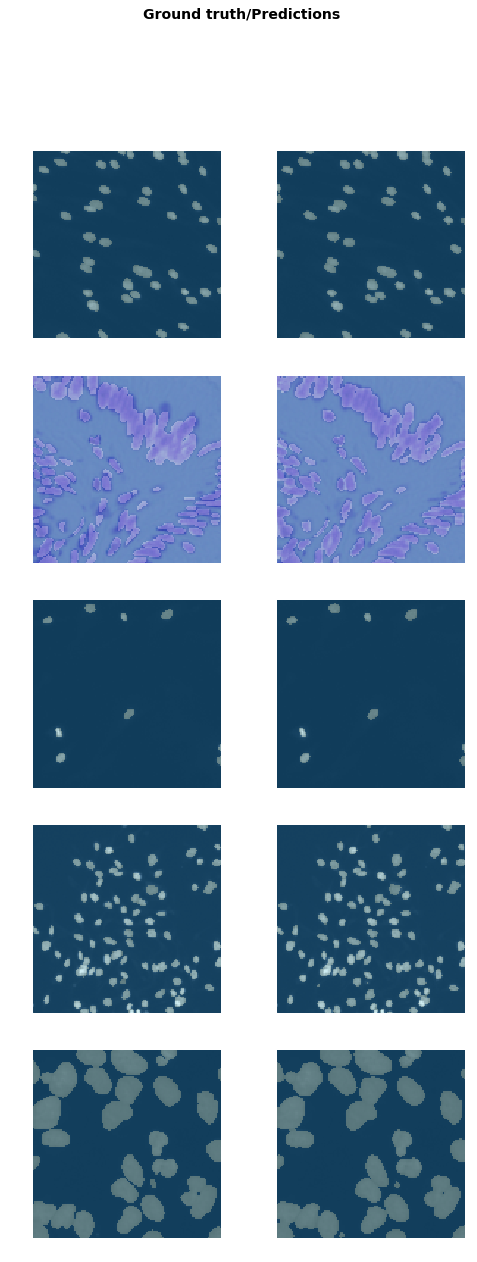

In [63]:
learn.show_results()

## size = 256

In [55]:
learn = learn.load('nucleus-stage2-128')

In [55]:
data256 = (src.transform(tfms, tfm_y=True, size=256)
       .databunch(bs=8))
learn.data = data256

In [57]:
learn = learn.to_fp16()

In [58]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


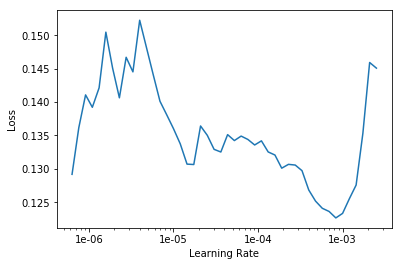

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
lrs = slice(5e-5,6e-4)

In [61]:
learn.fit_one_cycle(6, max_lr=lrs)

epoch,train_loss,valid_loss,dice,time
0,0.100871,0.079148,0.788073,01:19
1,0.088171,0.068855,0.830570,01:18
2,0.084902,0.074616,0.812053,01:18
3,0.073679,0.056833,0.851413,01:18
4,0.067004,0.055610,0.857263,01:18
5,0.062095,0.055902,0.854534,01:18


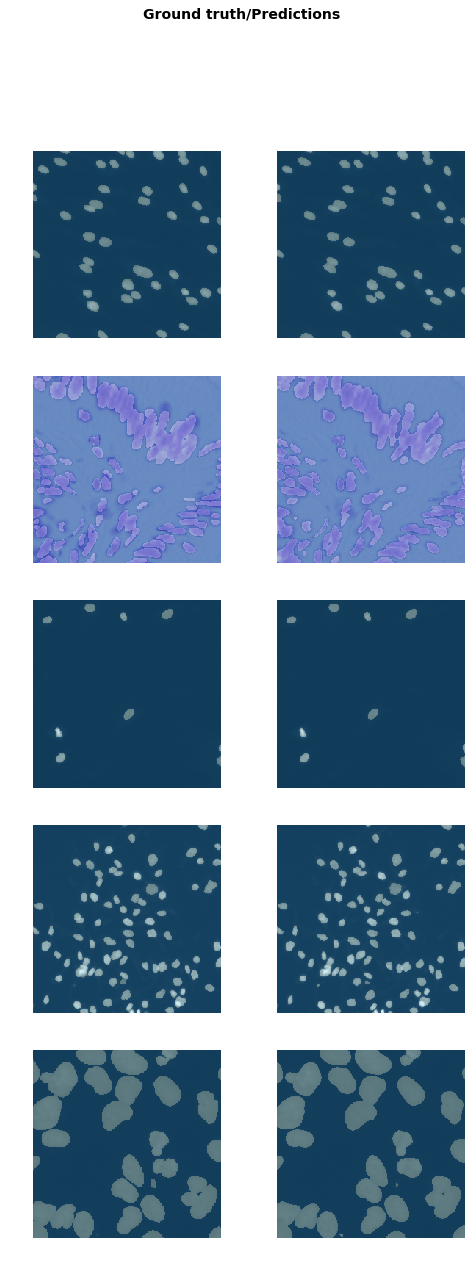

In [62]:
learn.show_results()

In [39]:
learn.unfreeze()

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


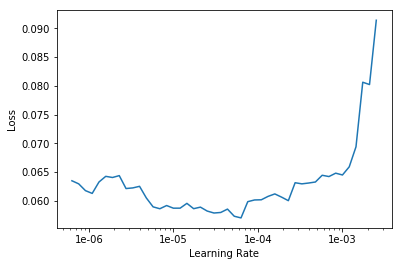

In [45]:
learn.recorder.plot()

In [47]:
learn.lr_find(start_lr=1e-9)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


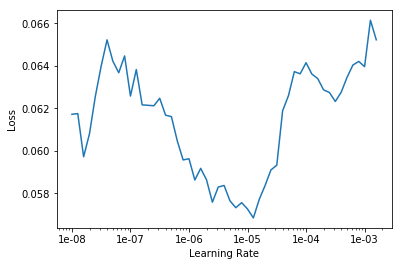

In [48]:
learn.recorder.plot()

In [49]:
lrs = slice(1e-7,1e-6)

In [50]:
learn.fit_one_cycle(2, max_lr=lrs)

epoch,train_loss,valid_loss,dice,time
0,0.062340,0.054986,0.859063,01:21
1,0.063473,0.055346,0.858364,01:21


In [51]:
learn.save('nucleus-stage2-256')

In [ ]:
learn = learn.load('nucleus-stage2-256')

In [52]:
learn.fit_one_cycle(5, max_lr=lrs)

epoch,train_loss,valid_loss,dice,time
0,0.060979,0.055099,0.858946,01:21
1,0.061046,0.054418,0.859187,01:21
2,0.062556,0.054540,0.858968,01:21
3,0.062650,0.054808,0.858975,01:21
4,0.059773,0.055845,0.857757,01:21


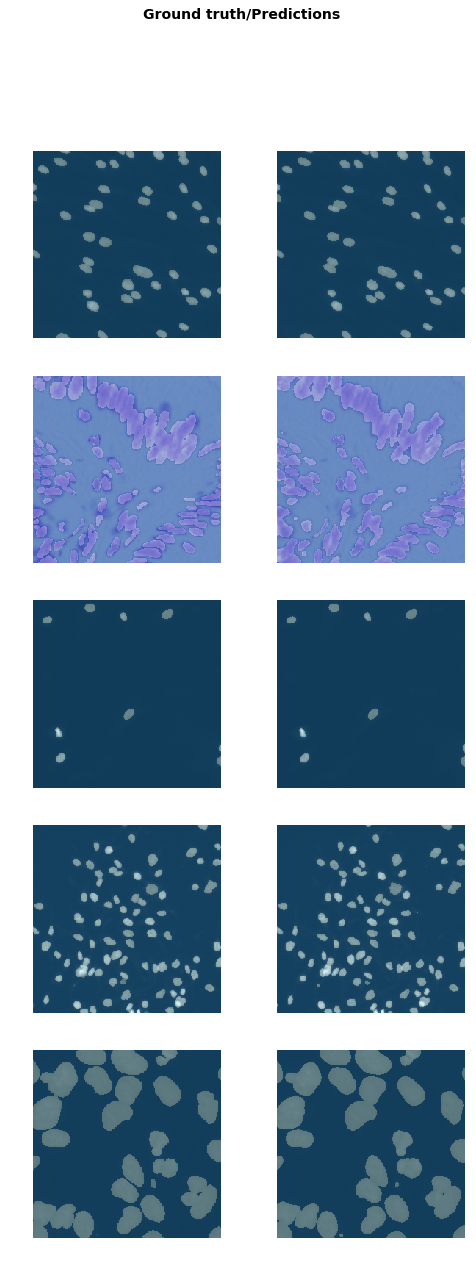

In [64]:
learn.show_results()

## size = 512 

In [34]:
learn = learn.load('nucleus-stage2-256')

In [74]:
data512 = (src.transform(tfms, tfm_y=True, size=512)
       .databunch(bs=4))
learn.data = data512

In [75]:
learn = learn.to_fp16()

In [76]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


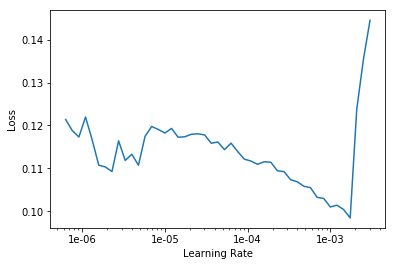

In [77]:
learn.lr_find()
learn.recorder.plot()

In [78]:
lrs = slice(5e-4,5e-3)

In [79]:
learn.fit_one_cycle(2, max_lr=lrs)

epoch,train_loss,valid_loss,dice,time
0,nan,nan,0.000000,05:04
1,nan,nan,0.000000,05:00


In [81]:
learn.show_results??

# Prediction

The model above resizes the input and output images for training.

To submit must predict each image in test set based on what size it is?

would it be possible to do this?

In [35]:
learn = learn.load('nucleus-stage2-256')

In [36]:
learn = learn.to_fp32()

In [97]:
data256

ImageDataBunch;

Train: LabelList (536 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/ubuntu/data/fastai/data/nuclei/train;

Valid: LabelList (134 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/ubuntu/data/fastai/data/nuclei/train;

Test: None

In [108]:
x = data256.train_ds[0][0]

In [109]:
pred = learn.predict(x)

In [110]:
pred, y_pred ,x_pred = pred

In [115]:
open_mask_rle??

In [123]:
y_pred

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [172]:
y_pred.numpy().shape[1:]

(256, 256)

In [174]:
rle_encode??

In [175]:
rle_test = rle_encode(y_pred)

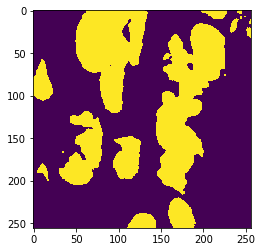

In [178]:
plt.imshow(rle_decode(rle_test, y_pred.numpy().shape[1:]))

In [39]:
test_path = path/'stage1_test'; test_path.ls()[:2]

[PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_test/44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_test/1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c')]

In [40]:
test_images_fnames = [ ({'imgId': i.stem, 'path':i/f'images/{i.stem}.png' }) for i in test_path.ls()]

In [41]:
test_images_fnames[0]

{'imgId': '44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078',
 'path': PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_test/44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078/images/44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078.png')}

In [42]:
image2np(test_images_fnames[0]["path"]).shape

(512, 680, 3)

In [43]:
def imageRGB2np(path):
    x = plt.imread(str(path))
    a = np.asarray(x)
    a = a[:,:,:3]
    return a.astype(np.float32, copy=False)

In [44]:
np.amax([ x.shape[2] for x in ([ image2np(i['path']) for i in test_images_fnames ])])

4

In [45]:
test_x = [ imageRGB2np(i['path']) for i in test_images_fnames ];

In [131]:
test_x_sizes = [ x.shape[:2] for x in test_x]; test_x_sizes[0]

(512, 680)

In [47]:
'max channels in test set data',np.amax([ x.shape[2] for x in test_x])

('max channels in test set data', 3)

In [156]:
def imgShape(path): return image2np(path).shape

In [157]:
test_img_shapes = [ imgShape(i['path']) for i in test_images_fnames ]; test_img_shapes[0]


(512, 680, 3)

In [158]:
sizes_test = [ i[:2] for i in test_img_shapes]; sizes_test[0]

(512, 680)

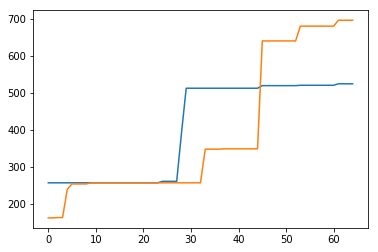

In [159]:
plt.plot(np.sort(sizes_test, axis=0))
plt.show()

In [181]:
from skimage.transform import resize as ski_resize

In [186]:
test_x.__len__()

65

In [193]:
vision.image.Image()

In [194]:
x = data256.train_ds[0][0]

In [315]:
x.shape

torch.Size([3, 256, 256])

In [341]:
x_image = vision.image.Image(test_x[0])

In [333]:
x_tensor = torch.from_numpy(test_x[0]).transpose(2, 0)

In [336]:
x_tensor.shape, test_x[0].shape

(torch.Size([3, 680, 512]), (512, 680, 3))

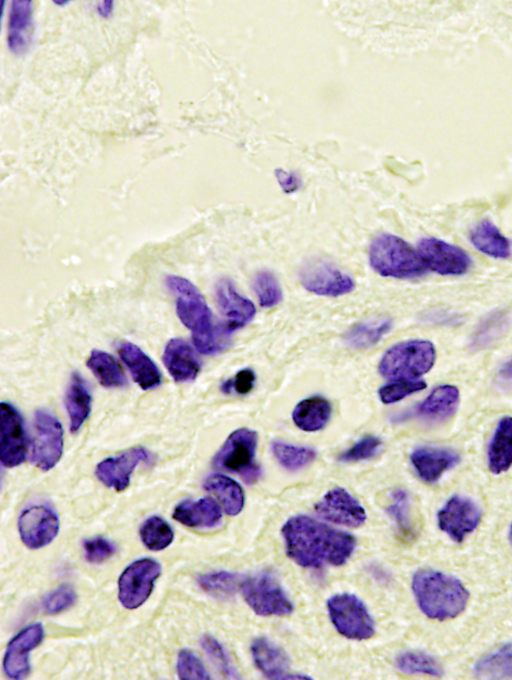

In [339]:
vision.image.Image(x_tensor)

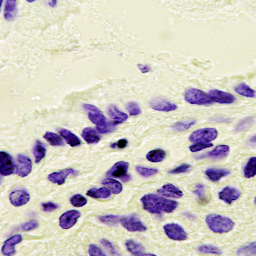

In [340]:
vision.image.Image(x_tensor).resize(256)

In [357]:
[ x.shape for x in test_x ]

[(512, 680, 3),
 (256, 256, 4),
 (256, 256, 3),
 (519, 253, 3),
 (524, 348, 3),
 (256, 256, 4),
 (256, 256, 4),
 (256, 256, 3),
 (519, 253, 3),
 (519, 162, 3),
 (519, 161, 3),
 (512, 640, 4),
 (512, 680, 3),
 (512, 680, 3),
 (519, 162, 3),
 (256, 256, 3),
 (260, 347, 4),
 (256, 256, 4),
 (256, 256, 4),
 (512, 680, 3),
 (520, 696, 4),
 (512, 640, 4),
 (260, 347, 4),
 (390, 239, 4),
 (524, 348, 3),
 (519, 253, 3),
 (256, 256, 4),
 (520, 348, 3),
 (512, 640, 4),
 (512, 680, 3),
 (256, 256, 4),
 (524, 348, 3),
 (256, 256, 4),
 (256, 256, 4),
 (260, 347, 4),
 (256, 256, 4),
 (512, 640, 4),
 (524, 348, 3),
 (520, 696, 4),
 (512, 640, 4),
 (256, 256, 4),
 (256, 256, 4),
 (260, 347, 4),
 (512, 680, 3),
 (256, 256, 4),
 (519, 161, 3),
 (519, 253, 3),
 (256, 256, 3),
 (512, 640, 4),
 (520, 696, 4),
 (256, 256, 4),
 (256, 256, 4),
 (256, 256, 4),
 (512, 680, 3),
 (256, 256, 4),
 (520, 696, 4),
 (256, 256, 4),
 (520, 348, 3),
 (256, 256, 4),
 (520, 348, 3),
 (256, 256, 4),
 (512, 680, 3),
 (520, 3

In [56]:
def inputImage(arr):
    x = torch.from_numpy(arr).transpose(2, 0)
    return vision.image.Image(x).resize(256)

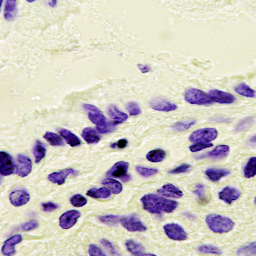

In [57]:
inputImage(test_x[0])

In [58]:
testImageList = [ inputImage(i) for i in test_x ]

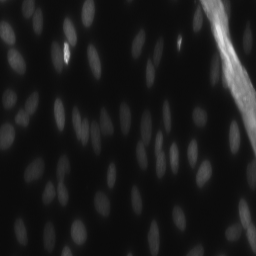

In [59]:
testImageList[3]

In [110]:
test_preds = [ learn.predict(x) for x in testImageList ]

In [111]:
x = test_preds[0]


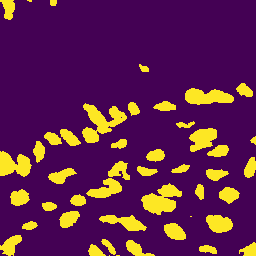

In [112]:
x[0]

In [114]:
# vision.image.Image(x[1]).resize()

In [115]:
import copy

In [141]:
# upsample the predicted masks!

img, y_pred, x = test_preds[1]
size_1 = test_x_sizes[0]

print(img.data.shape, (1, *size_1))


# print(imgSegment)
# imgSegment.flow = my_affine_grid(y_pred.shape)
# img.flow
# imgS.refresh()

newThing = copy.deepcopy(img)
newThing.flow = my_affine_grid((1, *size_1))
newThing.resize((1, *size_1))


# my_affine_grid(y_pred.shape).flow
# for preds, sizes in zip(test_preds, test_x_sizes):
#     imgSegment, y_pred, x = preds
#     print(sizes, y_pred.shape)
    

torch.Size([1, 256, 256]) (1, 512, 680)


AssertionError: 

In [69]:
def my_affine_grid(size:TensorImageSize)->FlowField:
    size = ((1,)+size)
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return FlowField(size[2:], grid)

In [70]:
my_affine_grid((1,256,256))

FlowField(size=(256, 256), flow=tensor([[[[-1.0000, -1.0000],
          [-0.9922, -1.0000],
          [-0.9843, -1.0000],
          ...,
          [ 0.9843, -1.0000],
          [ 0.9922, -1.0000],
          [ 1.0000, -1.0000]],

         [[-1.0000, -0.9922],
          [-0.9922, -0.9922],
          [-0.9843, -0.9922],
          ...,
          [ 0.9843, -0.9922],
          [ 0.9922, -0.9922],
          [ 1.0000, -0.9922]],

         [[-1.0000, -0.9843],
          [-0.9922, -0.9843],
          [-0.9843, -0.9843],
          ...,
          [ 0.9843, -0.9843],
          [ 0.9922, -0.9843],
          [ 1.0000, -0.9843]],

         ...,

         [[-1.0000,  0.9843],
          [-0.9922,  0.9843],
          [-0.9843,  0.9843],
          ...,
          [ 0.9843,  0.9843],
          [ 0.9922,  0.9843],
          [ 1.0000,  0.9843]],

         [[-1.0000,  0.9922],
          [-0.9922,  0.9922],
          [-0.9843,  0.9922],
          ...,
          [ 0.9843,  0.9922],
          [ 0.9922,  0.9922],


In [298]:
x = data256.train_ds[0][0]

In [301]:
vision.image.Image??

In [291]:
y_pred = learn.predict(vision.image.Image(x.data).resize((1000)))

SyntaxError: unexpected EOF while parsing (<ipython-input-291-abc801c22ee4>, line 1)

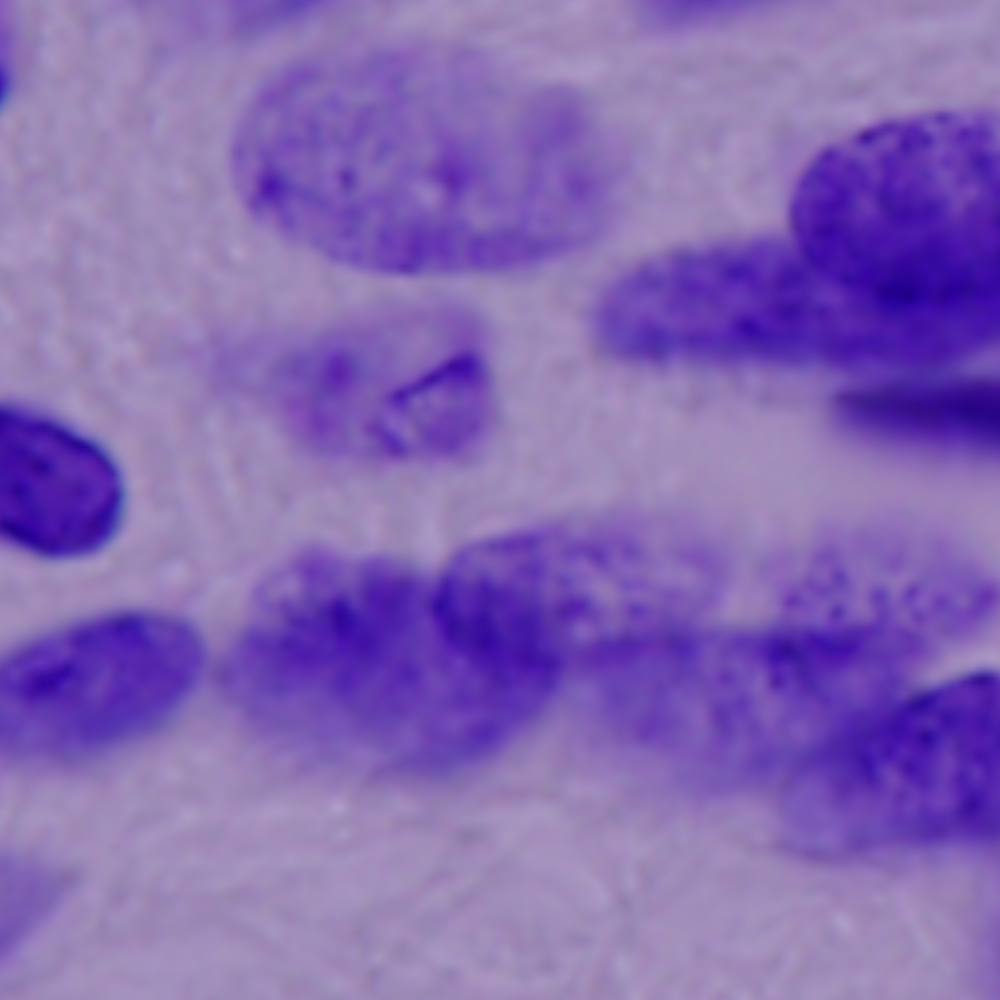

In [294]:
vision.image.Image(x.data).resize((1000))

In [ ]:
learn.predict(vision.image.Image(x.data).resize

In [ ]:
y_pred = learn.predict(vision.image.Image(x.data).resize

In [284]:
y_pred[1].numpy().shape

(1, 256, 256)

In [288]:
ski_resize(y_pred[1].numpy(), (1,500,500))

array([[[5.421011e-20, 5.421011e-20, 5.421011e-20, 5.421011e-20, ..., 5.421011e-20, 5.421011e-20, 5.421011e-20,
         5.421011e-20],
        [5.421011e-20, 5.421011e-20, 5.421011e-20, 5.421011e-20, ..., 5.421011e-20, 5.421011e-20, 5.421011e-20,
         5.421011e-20],
        [5.421011e-20, 5.421011e-20, 5.421011e-20, 5.421011e-20, ..., 5.421011e-20, 5.421011e-20, 5.421011e-20,
         5.421011e-20],
        [5.421011e-20, 5.421011e-20, 5.421011e-20, 5.421011e-20, ..., 5.421011e-20, 5.421011e-20, 5.421011e-20,
         5.421011e-20],
        ...,
        [5.421011e-20, 5.421011e-20, 5.421011e-20, 5.421011e-20, ..., 5.421011e-20, 5.421011e-20, 5.421011e-20,
         5.421011e-20],
        [5.421011e-20, 5.421011e-20, 5.421011e-20, 5.421011e-20, ..., 5.421011e-20, 5.945765e-20, 7.167010e-20,
         7.224256e-20],
        [5.421011e-20, 5.421011e-20, 5.421011e-20, 5.421011e-20, ..., 5.421011e-20, 7.167010e-20, 1.123043e-19,
         1.142090e-19],
        [5.421011e-20, 5.421011e-20

In [265]:
test_fpaths = [ i["path"] for i in test_images_fnames]; test_fpaths[0]

PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_test/44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078/images/44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078.png')

In [266]:
test_fpaths[0].stem

'44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078'

### make the test set

In [272]:
for img in test_fpaths:
    newPath = path/f'test/{img.stem}.png'
    if not newPath.is_file():
        !cp {str(img)} {str(newPath)}

In [273]:
test_path = path/'test'

SegmentationItemList (65 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 520, 696),Image (3, 524, 348),Image (3, 256, 256)
Path: /home/ubuntu/data/fastai/data/nuclei/test

In [65]:
# stolen from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)